<a href="https://colab.research.google.com/github/Nadian-Ali/ImageClassification/blob/main/ViTimageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Vision Transformer

The original code was implemetned by Khalid Salma
I changed the code for the X-ray classificaiton task 
**Author:** [Khalid Salama](https://www.linkedin.com/in/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [ ]:
data_dir = '/content/drive/MyDrive/ImageClassification/flower_photos'

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from keras.preprocessing import image

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode = "grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 1066 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  color_mode = "grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 266 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [ ]:
num_classes = 2
input_shape = (180, 180, 1)




## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 18  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
num_patches

16

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
#data_augmentation.layers[0].adapt(train_ds)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer



In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model



In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1,activation = 'sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )



In [ ]:
vit_classifier = create_vit_classifier()

vit_classifier.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
            #keras.metrics.BinaryCrossentropy(name="accuracy"),
#            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        #],
    )

In [ ]:
epochs = 20
history = vit_classifier.fit(
        x=train_ds,
        #y=val_ds,
        #batch_size=batch_size,
        validation_data=val_ds,
        epochs=epochs,
      #  validation_split=0.1,
      #  callbacks=[checkpoint_callback],
    )

Epoch 1/20
34/34 [==============================] - 24s 327ms/step - loss: 1.1344 - accuracy: 0.5460 - val_loss: 0.5904 - val_accuracy: 0.6842
Epoch 2/20
34/34 [==============================] - 10s 281ms/step - loss: 0.7486 - accuracy: 0.6032 - val_loss: 0.7827 - val_accuracy: 0.5150
Epoch 3/20
34/34 [==============================] - 12s 336ms/step - loss: 0.6774 - accuracy: 0.6304 - val_loss: 0.6047 - val_accuracy: 0.6880
Epoch 4/20
34/34 [==============================] - 12s 332ms/step - loss: 0.6685 - accuracy: 0.6407 - val_loss: 0.6301 - val_accuracy: 0.6880
Epoch 5/20
34/34 [==============================] - 10s 288ms/step - loss: 0.6363 - accuracy: 0.6379 - val_loss: 0.7175 - val_accuracy: 0.5263
Epoch 6/20
34/34 [==============================] - 11s 312ms/step - loss: 0.6372 - accuracy: 0.6295 - val_loss: 0.6330 - val_accuracy: 0.6128
Epoch 7/20
34/34 [==============================] - 10s 279ms/step - loss: 0.6309 - accuracy: 0.6445 - val_loss: 0.6247 - val_accuracy: 0.6128

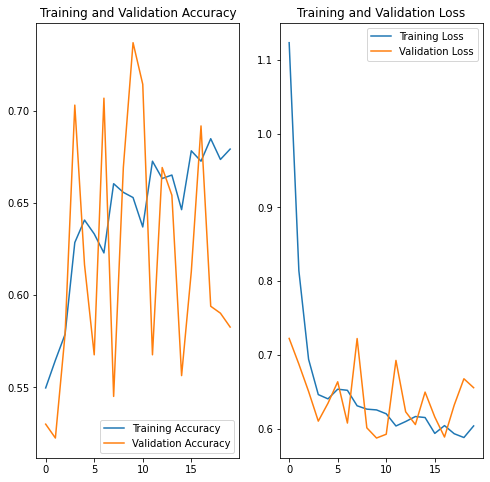

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1>Do Prediction</h1>

In [ ]:
from tensorflow.python.tf2 import enabled
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

im_pd = '/content/drive/MyDrive/ImageClassification/flower_photos/daisy/286875003_f7c0e1882d.jpg'
im_ps = '/content/drive/MyDrive/ImageClassification/flower_photos/sunflowers/200557981_f800fa1af9.jpg'

img = tf.keras.utils.load_img(
    im_ps,
    color_mode = "grayscale", 
    target_size=(img_height, img_width),
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_mine.predict(img_array)
#score = tf.nn.softmax(predictions[0])

print(predictions)
if predictions>0.5:
  print('image belongs to class sunflower')
else:
  print('image belongs to class daisy')  

<h1>Save model , load model and Predict</h1>